# NCO and HW modulation demo

In [1]:
import json
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from cluster.cluster import cluster_qrm
from scipy import signal

For this example we are using a Cluster QRM with $(O_1, O_2) \rightarrow (I_1, I_2)$.

In [2]:
qrm = cluster_qrm("cluster_qrm", "192.168.0.26")
qrm.reset()

We define the waveforms: a gaussian and a constant zero.

In [3]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {"data": signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(), "index": 0},
    "zero": {"data": [0.0 for i in range(0, waveform_length)], "index": 1},
}

Notice that the waveforms are only envelopes, they don't carry any frequency information.

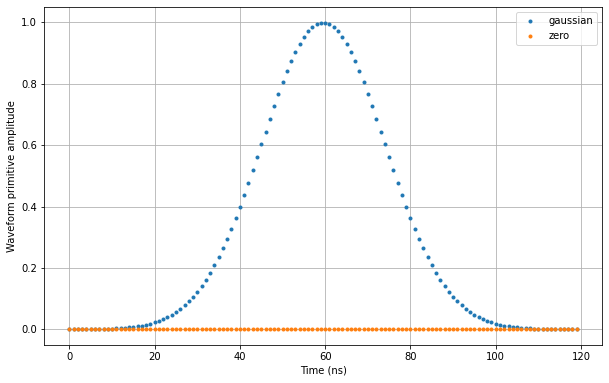

In [4]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".", label=wf)

ax.legend(loc=1)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

An acquisitions dictionary is defined as usual

In [5]:
# Acquisitions
acquisitions = {"single": {"num_bins": 1, "index": 0}}

Now we enable the hardware modulation for the sequencer 0 and set $f_{\text{NCO}}=100\text{MHz}$

In [6]:
qrm.sequencer0_mod_en_awg(True)
qrm.sequencer0_nco_freq(100e6)

Enabling the hardware modulation allows us to use all the phase control sequencer instructions like `reset_ph`, `set_ph` and `set_ph_delta`. To demonstrate its usage, in the following program we do the following steps
1. Start acquiring.
2. Play the stored waveforms on outputs $O_1$ and $O_2$.
3. Once the output of the waveforms is complete, increment by $\pi$ the phase of the NCO.
4. Play the same waveforms.
5. Wait until the acquisition is full and stop.

The sequencer instructions can't take floats as arguments, so they make you decompose your desired phase in different granularities: coarse (steps of 0.9º), fine (steps of 2.25e-3º) and ultrafine (steps of 3.6e-7º). For your typical rotations you will only need round numbers of the coarse granularity while setting the fine and ultrafine to zero.
- coarse = 0 $\rightarrow$ 0
- coarse = 50 $\rightarrow$ $\pi/4$
- coarse = 100 $\rightarrow$ $\pi/2$
- coarse = 200 $\rightarrow$ $\pi$
- coarse = 300 $\rightarrow$ $3\pi/2$
- ...

Anyway, you can easily write a function like the following `decomp_phase(deg)` that decomposes any value in degrees to coarse, fine and ultrafine.

In [15]:
def decomp_phase(deg):
    coarse = int(deg / 0.9)
    deg -= coarse * 0.9
    fine = int(deg / 2.25e-3)
    deg -= fine * 2.25e-3
    ultrafine = int(deg / 3.6e-7)
    return coarse, fine, ultrafine


delta_ph_in_degrees = 127.4739531
coarse, fine, ultrafine = decomp_phase(delta_ph_in_degrees)
print(f"{delta_ph_in_degrees} degrees → coarse={coarse}, fine={fine}, ultrafine={ultrafine}.")

127.4739531 degrees → coarse=141, fine=255, ultrafine=564.


In [8]:
# Sequence program.
seq_prog = f"""
reset_ph                          #Reset absolute phase
acquire 0,0,4 #Acquire waveforms and wait remaining duration of scope acquisition.
play    0,1,4     #Play waveforms and wait 4ns.
wait    {waveform_length - 4}
set_ph_delta {coarse}, {fine}, {ultrafine}
play    0,1,4     #Play waveforms and wait 4ns.
wait {16248 - 2*(waveform_length - 4)}
stop              #Stop.
"""

Now we can perform all the steps of your typical QRM self-read demo:
- Upload the sequence
- Configure sequencer mapping (map ports of the sequencer 0 to the ports of the QRM)
- Arm and play sequencer
- Store and plot the acquisitions

In [9]:
# Add sequence to single dictionary and write to JSON file.
sequence = {"waveforms": waveforms, "weights": {}, "acquisitions": acquisitions, "program": seq_prog}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [10]:
# Upload waveforms and programs.
qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

In [11]:
# Configure the sequencer to trigger the scope acquisition.
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Map sequencer to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        qrm.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out % 2, out), False)
qrm.sequencer0_channel_map_path0_out0_en(True)
qrm.sequencer0_channel_map_path1_out1_en(True)

In [12]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print("Status:")
print(qrm.get_sequencer_state(0))

Status:
{'status': 'STOPPED', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


In [13]:
# Wait for the acquisition to finish with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "single")

# Get acquisition list from instrument.
single_acq = qrm.get_acquisitions(0)

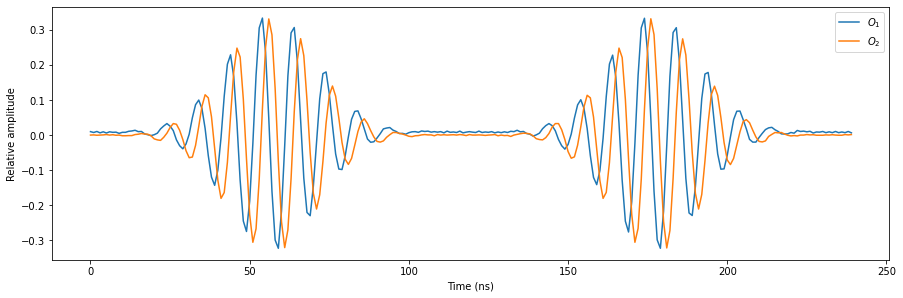

In [14]:
# Plot acquired signal on both inputs.

O1 = single_acq["single"]["acquisition"]["scope"]["path0"]["data"][160:400]
O2 = single_acq["single"]["acquisition"]["scope"]["path1"]["data"][160:400]

fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(O1, label=r"$O_1$")
ax.plot(O2, label="$O_2$")
ax.legend(loc=1)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

As you can observe in the plot above, the hardware has performed the following operation
$$
\begin{pmatrix}
O_1\\
O_2
\end{pmatrix}
=
\begin{pmatrix}
c_\alpha & s_\alpha\\
-s_\alpha & c_\alpha
\end{pmatrix}
\begin{pmatrix}
w_0\\
w_1
\end{pmatrix}
$$
Where $\alpha = 2\pi t f_\text{NCO} $ and $w_0$ and $w_1$ are the waveforms that we stored at indices 0 and 1 (gaussian and zero).

This corresponds with the IQ modulation that we usually do via software, notice that doing so in the way shown in this notebook we can benefit of the following advantages:
1. Simpler code, since we don't need to do that matrix product anywhere.
2. The frequency is independent from the sequence, we can upload the sequence with the dictionary of waveforms and modify the NCO frequency later anytime.
3. All the phase control can be moved to the sequence program, where we can benefit from the robustness and versatility of the `reset_ph`, `set_ph` and `set_ph_delta` instructions.